# Projet TAL - RI
_Charlotte Kruzic & Zoé Marquis_
### Étape 1

In [1]:
!pip install pandas unidecode

Defaulting to user installation because normal site-packages is not writeable


In [2]:

# Imports nécessaires

%matplotlib inline

# Suppression de l'affichage des messages d'avertissement
import warnings
warnings.filterwarnings('ignore')

import string
import time
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn import metrics
from sklearn import model_selection
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


set_config(display='diagram')

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/zoe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/zoe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Charger les données & exploration

In [3]:
df_train = pd.read_csv("train.tsv", sep='\t')

In [4]:
df_train.head()

,category,headline,text,url
0,sports,"L'Ouganda à l'assaut des ""fimbu"" de la RDC","L'Ouganda, placé 79e au classement FIFA le 4 a...",https://www.bbc.com/afrique/sports-48730747
1,business,Stopper la détérioration de l’environnement po...,La responsable de la biodiversité des Nations ...,https://www.bbc.com/afrique/articles/cevdz4xrp42o
2,sports,Coupe d'Afrique des nations 2022 : le sélectio...,"Le sélectionneur de la Sierra Leone, John Keis...",https://www.bbc.com/afrique/region-59881445
3,business,Tissus africains : pourquoi les teintureries h...,"Depuis plus de six siècles, une vaste zone sit...",https://www.bbc.com/afrique/region-61202726
4,business,Les revenus pendant la pandémie des dix hommes...,"Pendant la pandémie de coronavirus, la richess...",https://www.bbc.com/afrique/monde-55812018


In [5]:
print(df_train.columns)

Index(['category', 'headline', 'text', 'url'], dtype='object')


### Nettoyer les données 

In [6]:
# identifier les valeurs manquantes
valeurs_manquantes = df_train.isnull().sum()
print(valeurs_manquantes) 
# pas de valeur manquante

category    0
headline    0
text        0
url         0
dtype: int64


In [7]:
# identifier les lignes dupliquées
dupliquees = df_train.duplicated()
print(dupliquees.sum())
# 1 ligne dupliquée

1


In [8]:
# supprimer les lignes dupliquées
df_train = df_train.drop_duplicates()
dupliquees = df_train.duplicated()
print(dupliquees.sum())

0


In [9]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1475 entries, 0 to 1475
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  1475 non-null   object
 1   headline  1475 non-null   object
 2   text      1475 non-null   object
 3   url       1475 non-null   object
dtypes: object(4)
memory usage: 57.6+ KB
None


Le jeu de données contient 1475 lignes.  
Toutes les colonnes contiennent du texte (donc il n'est pas nécessaire de traiter les données numériques).   
On s'intéresse seulement aux colonnes `headline` et `text`.

### Préparer les données pour l'apprentissage de la catégorie
à partir du titre et du texte uniquement

Séparation des données de la catégorie à prédire

In [10]:
X = df_train[['headline', 'text']]
y = df_train.category

In [11]:
X.head()

,headline,text
0,"L'Ouganda à l'assaut des ""fimbu"" de la RDC","L'Ouganda, placé 79e au classement FIFA le 4 a..."
1,Stopper la détérioration de l’environnement po...,La responsable de la biodiversité des Nations ...
2,Coupe d'Afrique des nations 2022 : le sélectio...,"Le sélectionneur de la Sierra Leone, John Keis..."
3,Tissus africains : pourquoi les teintureries h...,"Depuis plus de six siècles, une vaste zone sit..."
4,Les revenus pendant la pandémie des dix hommes...,"Pendant la pandémie de coronavirus, la richess..."


In [12]:
# afficher toutes les catégories
y.unique()

array(['sports', 'business', 'politics', 'health', 'technology'],
      dtype=object)

### Prétraitement des données

- Nettoyage du texte : supprimer les caractères spéciaux, les ponctuations, les accents convertir en minuscules
- Tokenisation
- Suppression des mots vides

In [13]:
def split_into_tokens_nltk(desc) :
    return word_tokenize(desc)

# Liste des mots vides de NLTK + signes de ponctuation
nltk_stopwords = stopwords.words('french')+list(string.punctuation)

On va essayer plusieurs prétraitements différents supplémentaires dont : 
- Lemmatisation
- Désuffixation
- N-grammes

In [14]:
stemmer = SnowballStemmer(language='french')

def stemming(text):
    words = nltk.word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

def stemming_transformer(X):
    return X.apply(stemming)

In [15]:
def lemmatize_text(text):
    # modèle français de Spacy
    nlp = spacy.load("fr_core_news_sm")
    lemmatized_text = ' '.join([token.lemma_ for token in nlp(text)])
    return lemmatized_text

def lemmatization_transformer(X):
    return X.apply(lemmatize_text)

On va essayer 3 types de traits : 
- TF-IDF (avec différentes fréquences)
- Sac de mots (avec différentes fréquences)
- Informations statistiques : longueur en nombre de caractères et nombre approximatif de phrases

In [16]:
def text_stats(descriptions):
    return [{"length": len(text), "num_sentences": text.count(".")}
            for text in descriptions]
    
text_stats_transformer = FunctionTransformer(text_stats)
text_stats_vectorizer = DictVectorizer(sparse=False)
min_max_scaler = MinMaxScaler()    

In [18]:
tfidf_001 = TfidfVectorizer(tokenizer=split_into_tokens_nltk,
                            lowercase=True, 
                            stop_words=nltk_stopwords,
                            min_df = 0.01)
bow_001 = CountVectorizer(tokenizer=split_into_tokens_nltk,
                          lowercase=True,
                          stop_words=nltk_stopwords,
                          min_df=0.01)

tfidf_001_ngram2 = TfidfVectorizer(tokenizer=split_into_tokens_nltk,
                            lowercase=True, 
                            stop_words=nltk_stopwords,
                            min_df = 0.01,
                            ngram_range=(1, 2)
                            )
bow_001_ngram2 = CountVectorizer(tokenizer=split_into_tokens_nltk,
                          lowercase=True,
                          stop_words=nltk_stopwords,
                          ngram_range=(1, 2),
                          min_df=0.01)

tfidf_001_ngram3 = TfidfVectorizer(tokenizer=split_into_tokens_nltk,
                            lowercase=True, 
                            stop_words=nltk_stopwords,
                            min_df = 0.01,
                            ngram_range=(1, 3)
                            )
bow_001_ngram3 = CountVectorizer(tokenizer=split_into_tokens_nltk,
                          lowercase=True,
                          stop_words=nltk_stopwords,
                          ngram_range=(1, 3),
                          min_df=0.01)

tfidf_001_ngram4 = TfidfVectorizer(tokenizer=split_into_tokens_nltk,
                            lowercase=True, 
                            stop_words=nltk_stopwords,
                            min_df = 0.01,
                            ngram_range=(1, 4)
                            )
bow_001_ngram4 = CountVectorizer(tokenizer=split_into_tokens_nltk,
                          lowercase=True,
                          stop_words=nltk_stopwords,
                          ngram_range=(1, 4),
                          min_df=0.01)

tfidf_010 = TfidfVectorizer(tokenizer=split_into_tokens_nltk,
                            lowercase=True, 
                            stop_words=nltk_stopwords,
                            min_df = 0.1)
bow_010 = CountVectorizer(tokenizer=split_into_tokens_nltk,
                          lowercase=True,
                          stop_words=nltk_stopwords,
                          min_df=0.1)

tfidf_005 = TfidfVectorizer(tokenizer=split_into_tokens_nltk,
                            lowercase=True, 
                            stop_words=nltk_stopwords,
                            min_df = 0.05)
bow_005 = CountVectorizer(tokenizer=split_into_tokens_nltk,
                          lowercase=True,
                          stop_words=nltk_stopwords,
                          min_df=0.05)

### Modèles

In [19]:
models = [
    ('Baseline', DummyClassifier(strategy='most_frequent')),
    ('Mutinomial NB', MultinomialNB()),
    ('CART', DecisionTreeClassifier()),
    ('LR', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Random forest', RandomForestClassifier()),
    ('SVM', SVC(kernel='rbf')),
]

### Évaluation

Validation croisée à 5 plis

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                    random_state=3, shuffle=True)

In [20]:
stratkfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

In [21]:
def evaluate(modele, trait):
    model_pipeline = make_pipeline(trait, modele)
    y_pred = model_selection.cross_val_predict(model_pipeline, X_train, y_train,
                                               cv=stratkfold, n_jobs=-1)
    return y_pred

In [22]:
def run(chaines, modeles):
    classification_reports = {}

    for identifiant, colonne_transformateur in chaines:
        classification_reports[identifiant] = {}
        
        for name, model in models :
            y_pred = evaluate(model, trait=colonne_transformateur)
            
            report = classification_report(y_train, y_pred, output_dict=True)
            
            classification_reports[identifiant][name] = {
                "accuracy" : report["accuracy"],
                "f1-score" : report["macro avg"]["f1-score"],
                "precision" : report["macro avg"]["precision"],
                "recall" : report["macro avg"]["recall"],
            }
        
    return classification_reports

### Afficher pour comparer

In [23]:
def afficher_chaines(reports):
    for chaine_num, chaine_data in reports.items():
        fig, axs = plt.subplots(2, 2, figsize=(8, 6))
        fig.suptitle(chaine_num) 

        metrics = ['accuracy', 'f1-score', 'precision', 'recall']

        for ax, metric in zip(axs.flatten(), metrics):
            model_names = list(chaine_data.keys())
            metric_values = [model_data[metric] for model_data in chaine_data.values()]
            
            
            mean_metric = np.mean(metric_values)
            max_metric = np.max(metric_values)
            
            ax.axvline(mean_metric, color='r', linestyle='--', label=f'Mean ({mean_metric:.2f})')
            ax.axvline(max_metric, color='g', linestyle='--', label=f'Max ({max_metric:.2f})')
            

            ax.barh(model_names, metric_values, color='b')
            ax.set_title(metric.upper()) 
            ax.set_xlabel(metric.capitalize())  
            ax.set_ylabel('Modèles')  
            ax.invert_yaxis()  
            ax.set_xlim(0, 1)
            
            ax.legend()
            
        plt.tight_layout()
        plt.show()

In [24]:
def comparer_chaines(reports):
    metrics = ['accuracy', 'f1-score', 'precision', 'recall']
    metric_values = {metric: [] for metric in metrics}

    for chaine_num, chaine_data in reports.items():
        longueur = len(chaine_data.keys())
        for model, values in chaine_data.items():
            for metric in metrics:
                metric_values[metric].append((chaine_num, model, values[metric]))
                

    for metric in metrics:
        fig, axs = plt.subplots(2, 2, figsize=(8, 6))
        fig.suptitle(f'Comparaison de la métrique {metric.capitalize()} par modèle')  # Titre de la figure

        for i, ax in enumerate(axs.flat):
            values = metric_values[metric][i*longueur:(i+1)*longueur]

            chaine_names = [value[0] for value in values]
            model_names = [value[1] for value in values]
            metric_scores = [value[2] for value in values]
            
            mean_metric_score = np.mean(metric_scores)
            max_metric_score = np.max(metric_scores)
            
            ax.axvline(mean_metric_score, color='r', linestyle='--', label=f'Moyenne ({mean_metric_score:.2f})')
            ax.axvline(max_metric_score, color='g', linestyle='--', label=f'Maximum ({max_metric_score:.2f})')

            ax.barh(model_names, metric_scores, color='b')
            ax.set_title(chaine_names[0])  
            ax.set_xlabel(chaine_names[0]) 
            ax.set_ylabel('Chaines')  
            ax.invert_yaxis() 
            ax.set_xlim(0, 1)
            ax.legend()
            
        plt.tight_layout()

    plt.show()


## Premières chaines

Le pré-traitement appliqué est :
- Nettoyage du texte : supprimer les caractères spéciaux, les ponctuations, les accents convertir en minuscules
- Tokenisation
- Suppression des mots vides

Et on utilise les traits suivants :

| n° | headline | text |
| --- | --- | --- |
| 1 | tf-idf (fréquence = 0.01) | tf-idf (fréquence = 0.01) | 
| 2 | sac de mots (fréquence = 0.01) | sac de mots (fréquence = 0.01) | 
| 3 | tf-idf (fréquence = 0.01) |  sac de mots (fréquence = 0.01) | 
| 4 | sac de mots (fréquence = 0.01) |  tf-idf (fréquence = 0.01) | 

In [26]:
chaines = [
    ('chain1', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_tfidf_001', tfidf_001, 'text'),
        ]
    )),
    
    ('chain2', ColumnTransformer(
        [
            ('headline_bow_001', bow_001, 'headline'),
            ('text_bow_001', bow_001, 'text'),
        ]
    )),
    
    ('chain3', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
        ]
    )),
    
    ('chain4', ColumnTransformer(
        [
            ('headline_bow_001', bow_001, 'headline'),
            ('text_tfidf_001', tfidf_001, 'text'),
        ]
    )),
]


In [ ]:
# Ignorer les avertissements spécifiques de scikit-learn
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

classification_reports = run(chaines, models)

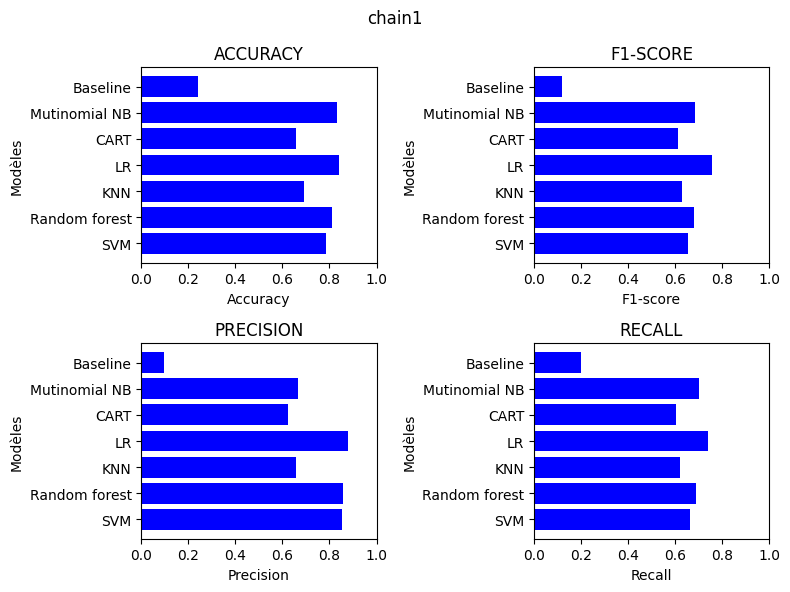

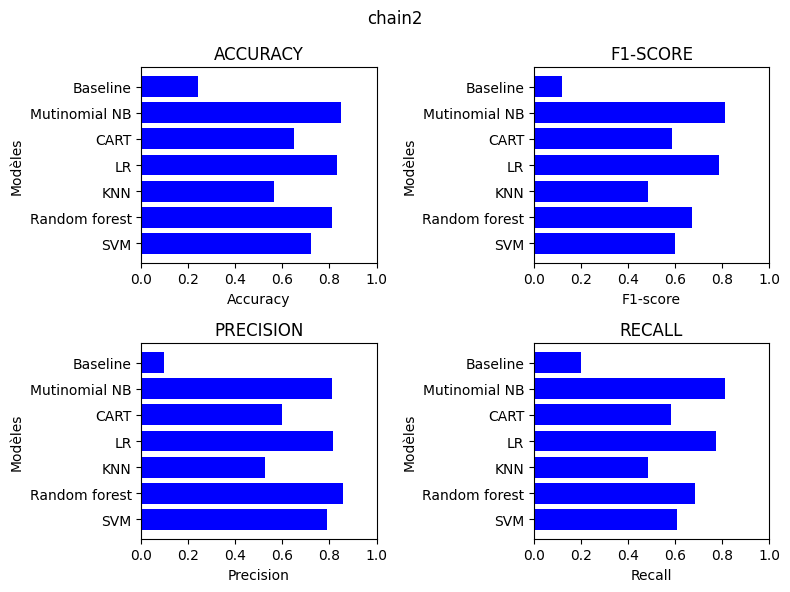

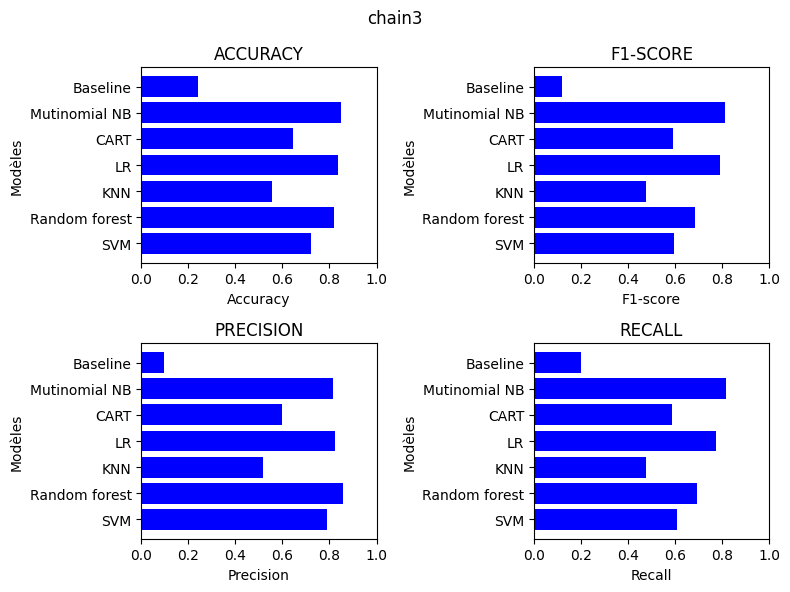

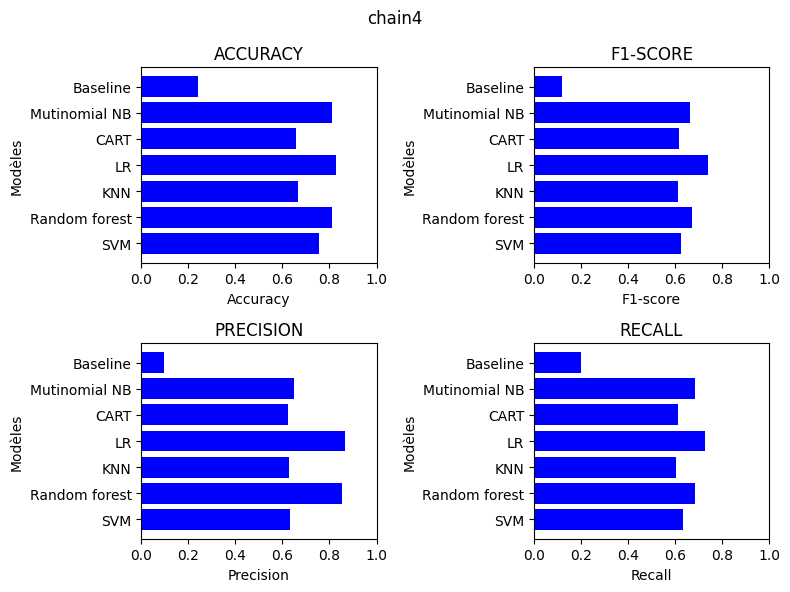

In [28]:
afficher_chaines(classification_reports)

On s'aperçoit tout de suite que les 4 meilleurs modèles sont (presque) à chaque fois 
- Multinomial NB
- LR (Régression Logistique)
- Random forest
- SVM

Nous redéfinissons donc la liste des modèles que nous utiliserons : 

In [49]:
models = [
    ('Mutinomial NB', MultinomialNB()),
    ('LR', LogisticRegression()),
    ('Random forest', RandomForestClassifier()),
    ('SVM', SVC(kernel='rbf')),
]

In [ ]:
# Ignorer les avertissements spécifiques de scikit-learn
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

classification_reports = run(chaines, models)

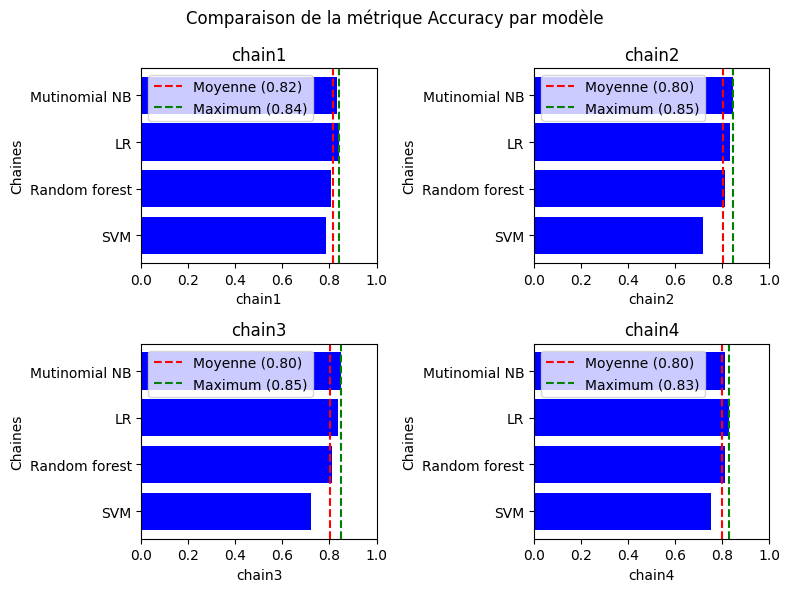

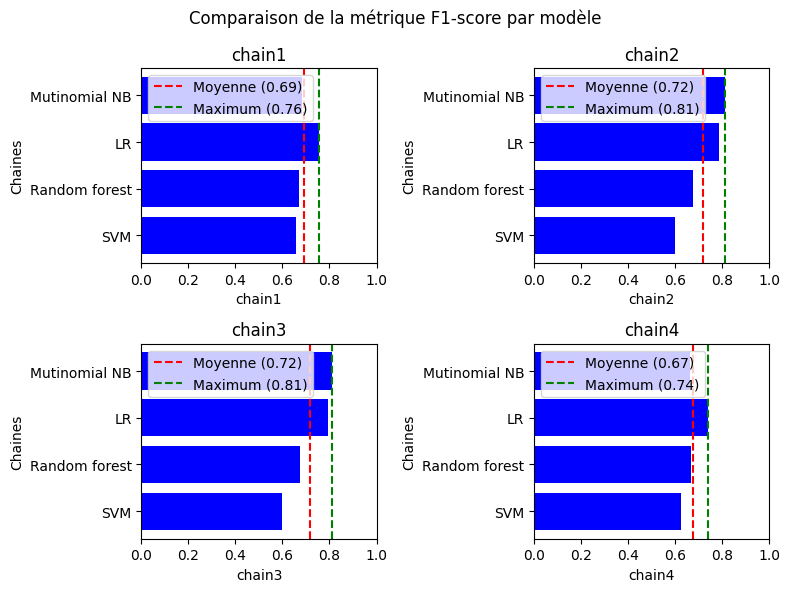

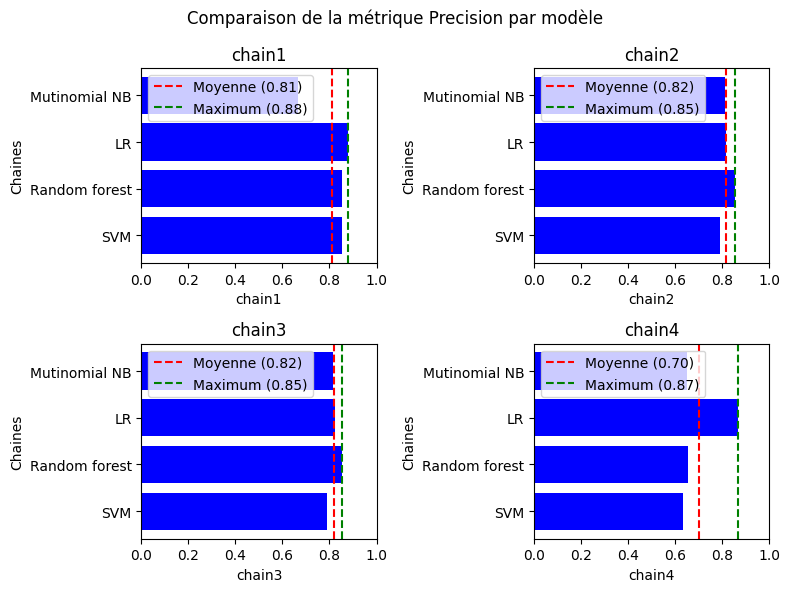

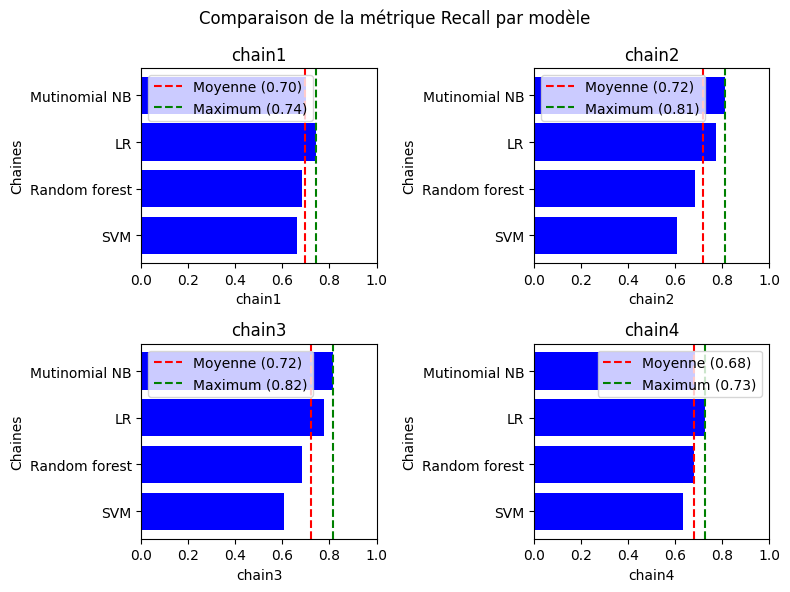

In [31]:
comparer_chaines(classification_reports)

On élimine les chaines 1 et 4 car elles ont un F1-score moins bons.

Essayons maintenant d'ajouter les traits d'informations statistiques.

## Deuxièmes chaines

Le pré-traitement appliqué est :
- Nettoyage du texte : supprimer les caractères spéciaux, les ponctuations, les accents convertir en minuscules
- Tokenisation
- Suppression des mots vides

Et on utilise les traits suivants :

| n° | headline | text |
| --- | --- | --- |
| 2 | sac de mots (fréquence = 0.01) | sac de mots (fréquence = 0.01) | 
| 3 | tf-idf (fréquence = 0.01) |  sac de mots (fréquence = 0.01) | 
| 5 | sac de mots (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques | 
| 6 | tf-idf (fréquence = 0.01) |  sac de mots (fréquence = 0.01) + informations statistiques | 

In [56]:
chaines = [
    ('chain2', ColumnTransformer(
        [
            ('headline_bow_001', bow_001, 'headline'),
            ('text_bow_001', bow_001, 'text'),
        ]
    )),
    
    ('chain3', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
        ]
    )),
    
    ('chain5', ColumnTransformer(
        [
            ('headline_bow_001', bow_001, 'headline'),
            ('text_bow_001', bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain6', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
]


In [54]:
# Ignorer les avertissements spécifiques de scikit-learn
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

classification_reports = run(chaines, models)

Chaine : chain2
Mutinomial NB


/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing t

LR


/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_

Random forest


/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing t

SVM


/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_

Chaine : chain3
Mutinomial NB


/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_

LR


/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_

Random forest


/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing t

SVM


/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_

Chaine : chain5
Mutinomial NB


/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing t

LR


/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_

Random forest


/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing t

SVM


/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_

Chaine : chain6
Mutinomial NB


/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_

LR


/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_

Random forest


/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_

SVM


/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_

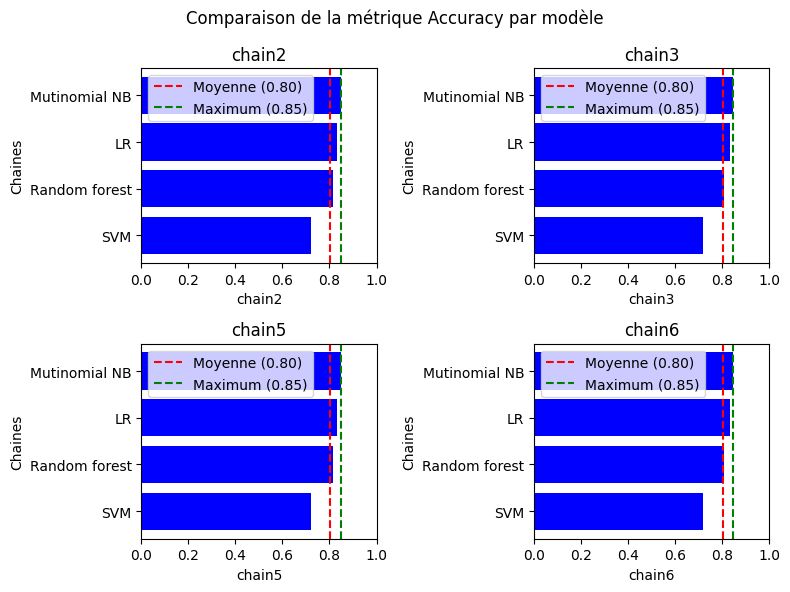

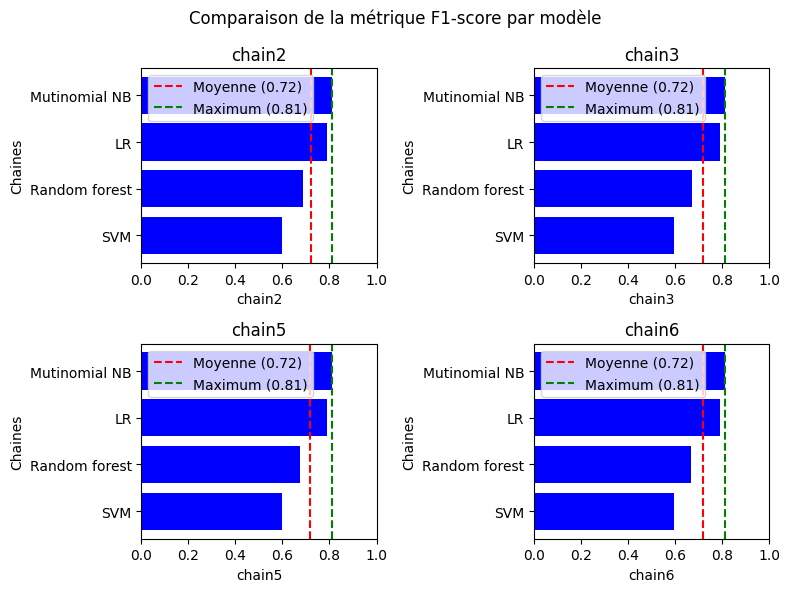

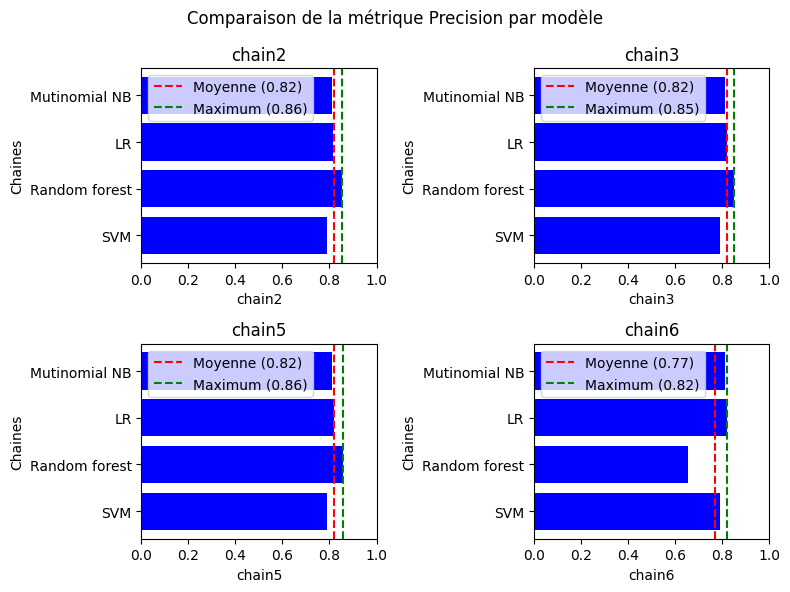

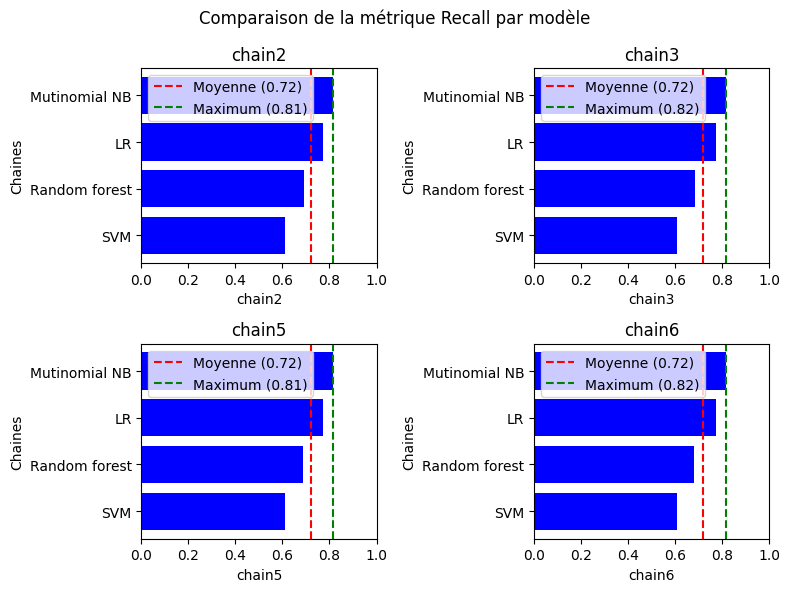

In [55]:
comparer_chaines(classification_reports)

Les mesures sont peu impactées par ce changement de traits.  
On garde la chaine 6 pour la suite car elle est légèrement meilleure lorsqu'il s'agit de Precision Rappel (pour la valeur maximale).   
On supprime aussi le modèle SVM qui n'est pas le plus performant.

In [25]:
models = [
    ('Mutinomial NB', MultinomialNB()),
    ('LR', LogisticRegression()),
    ('Random forest', RandomForestClassifier()),
]

## Troisièmes chaines

Le pré-traitement appliqué est :
- Nettoyage du texte : supprimer les caractères spéciaux, les ponctuations, les accents convertir en minuscules
- Tokenisation
- Suppression des mots vides
- **N-grammes**

Et on utilise les traits suivants :

| n° | headline | text | n-gramme |
| --- | --- | --- | --- |
| 6 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques | 
| 7 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques | 2 |
| 8 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques | 3 |
| 9 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques | 4 |

In [58]:
chaines = [
    ('chain6', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain7', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001_ngram2, 'headline'),
            ('text_bow_001',  bow_001_ngram2, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain8', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001_ngram3, 'headline'),
            ('text_bow_001',  bow_001_ngram3, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain9', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001_ngram4, 'headline'),
            ('text_bow_001',  bow_001_ngram4, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
]


In [ ]:
# Ignorer les avertissements spécifiques de scikit-learn
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

classification_reports = run(chaines, models)

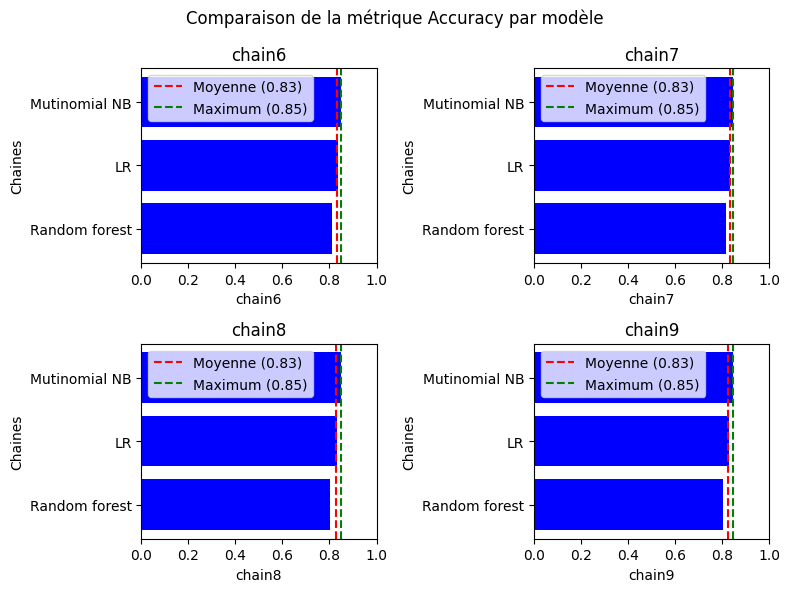

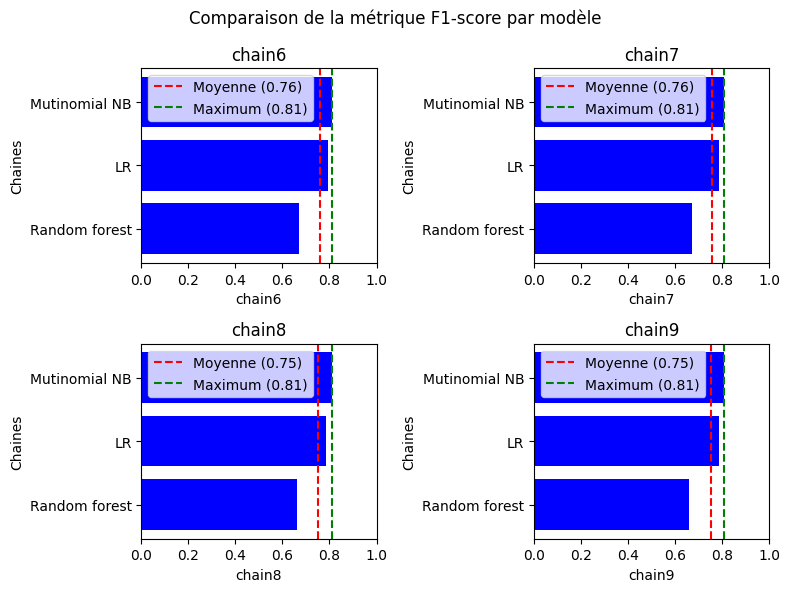

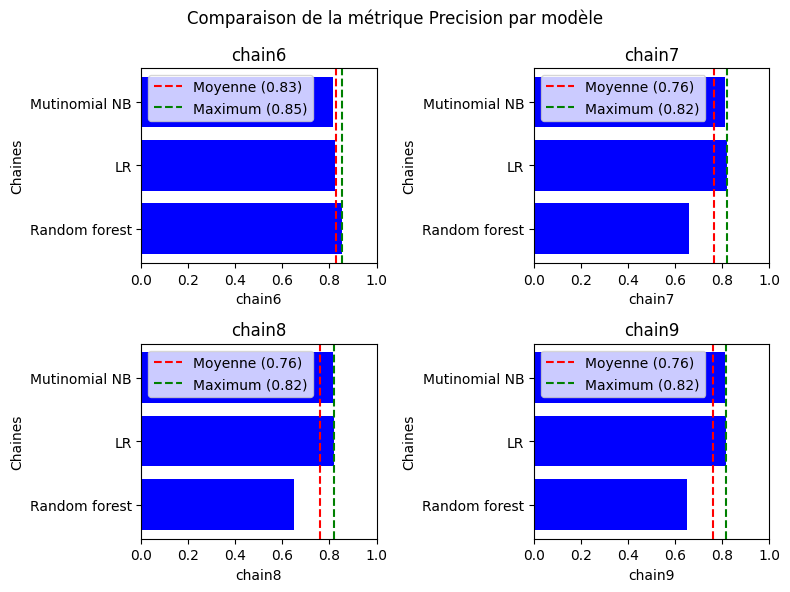

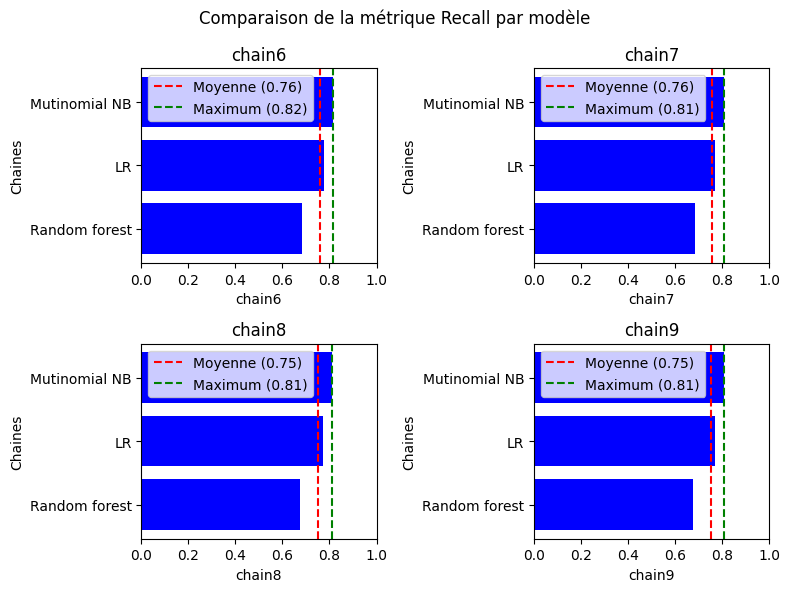

In [60]:
comparer_chaines(classification_reports)

On n'observe pas de modification, on garde la chaine 6.

On essaye les n-grammes lorsq'uon utilise TF-IDF pour le texte.

In [70]:
chaines = [
    ('chain6', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain7tfidf', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001_ngram2, 'headline'),
            ('text_bow_001',  tfidf_001_ngram2, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain8tfidf', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001_ngram3, 'headline'),
            ('text_bow_001',  tfidf_001_ngram3, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain9tfidf', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001_ngram4, 'headline'),
            ('text_bow_001',  tfidf_001_ngram4, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
]


In [ ]:
# Ignorer les avertissements spécifiques de scikit-learn
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

classification_reports = run(chaines, models)

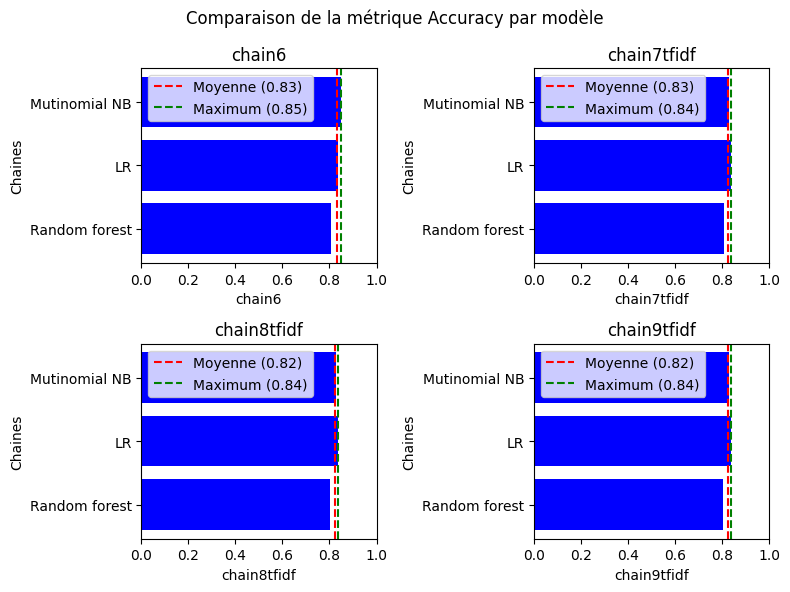

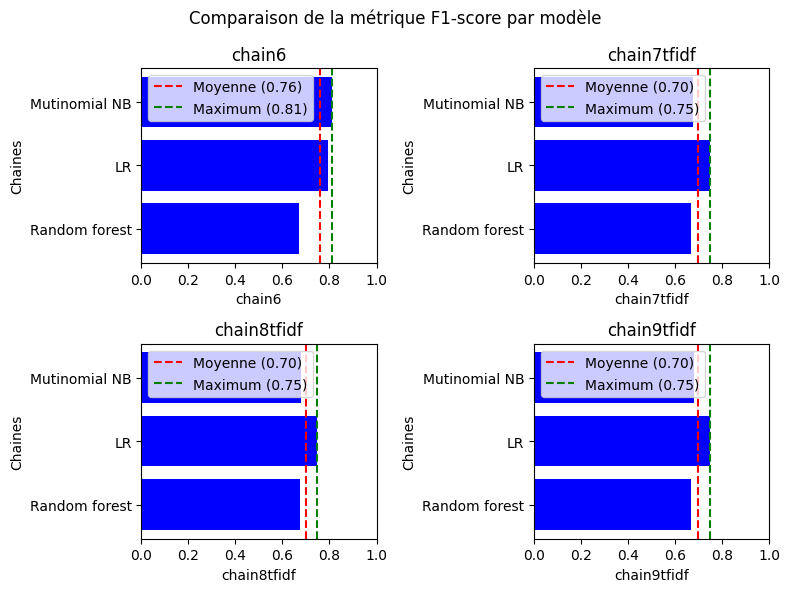

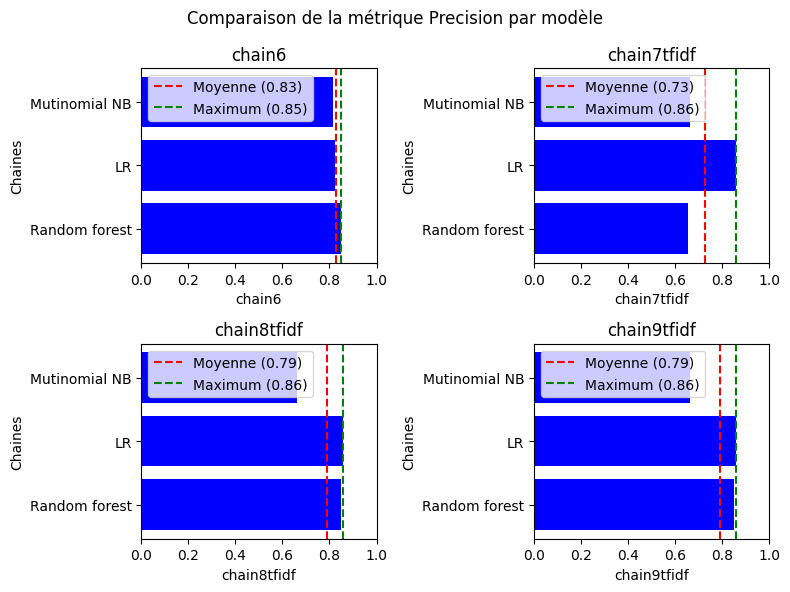

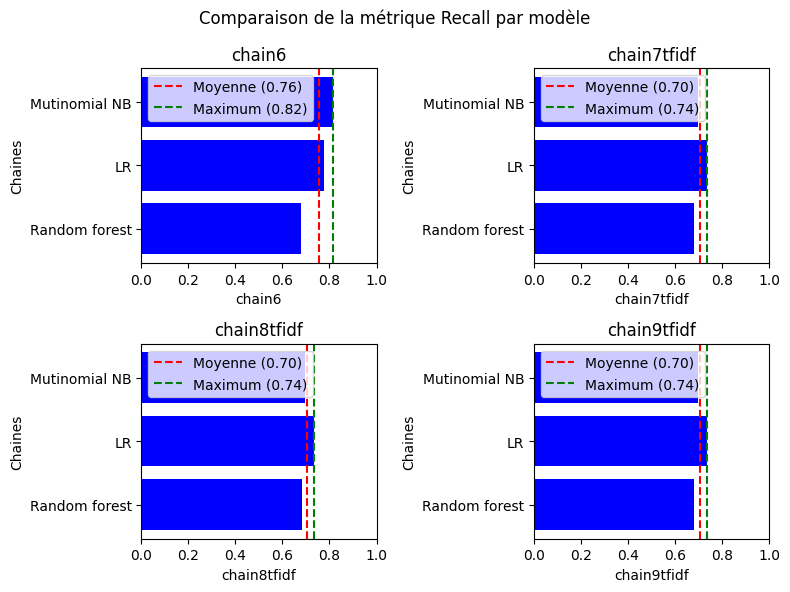

In [72]:
comparer_chaines(classification_reports)

On garde la chaine 6 : l'*accuracy* est identique mais le F1-score est moins bon.

## Quatrièmes chaines 

Le pré-traitement appliqué est :
- Nettoyage du texte : supprimer les caractères spéciaux, les ponctuations, les accents convertir en minuscules
- Tokenisation
- Suppression des mots vides
- **Fréquences** 

Et on utilise les traits suivants :

| n° | headline | text | 
| --- | --- | --- | 
| 6 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques | 
| 10 | tf-idf (fréquence = 0.1) | sac de mots (fréquence = 0.1) + informations statistiques | 
| 11 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.1) + informations statistiques | 
| 12 | tf-idf (fréquence = 0.1) | sac de mots (fréquence = 0.01) + informations statistiques | 

In [62]:
chaines = [
    ('chain6', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain10', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_010, 'headline'),
            ('text_bow_001',  bow_010, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain11', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001',  bow_010, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain12', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_010, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
]


In [ ]:
# Ignorer les avertissements spécifiques de scikit-learn
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

classification_reports = run(chaines, models)

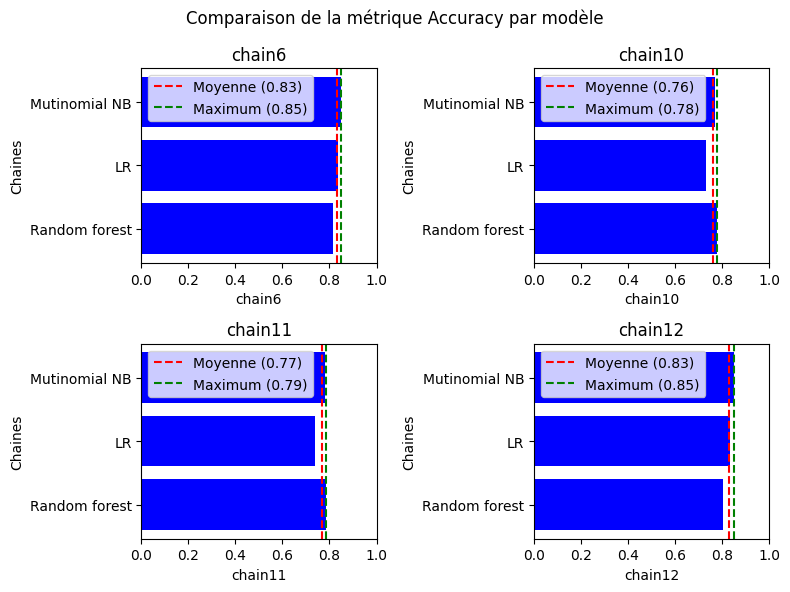

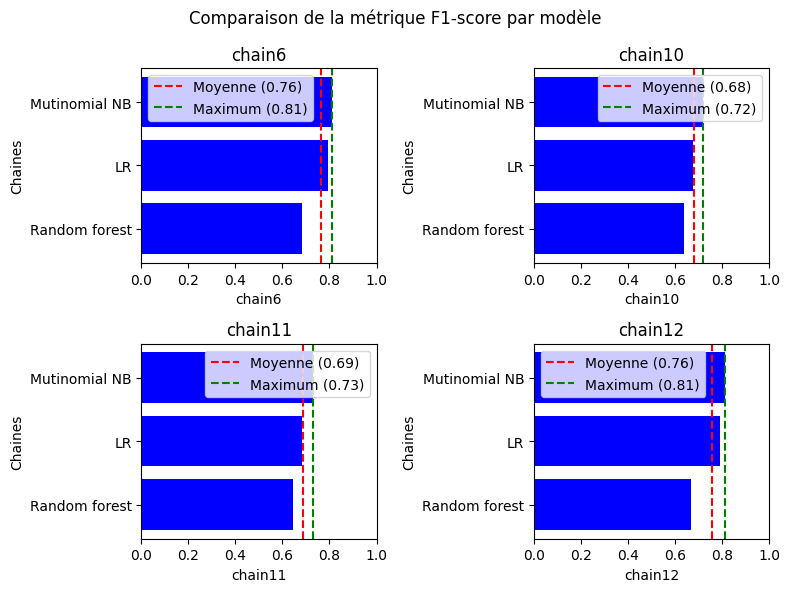

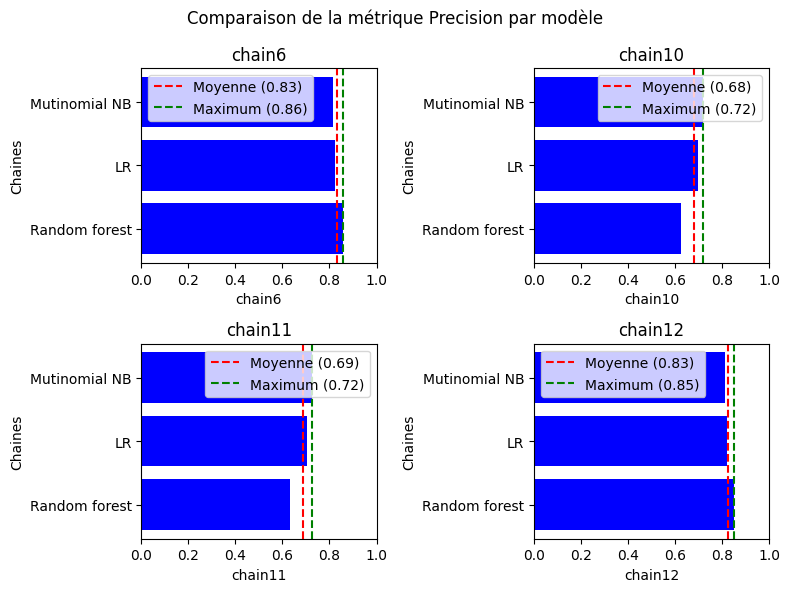

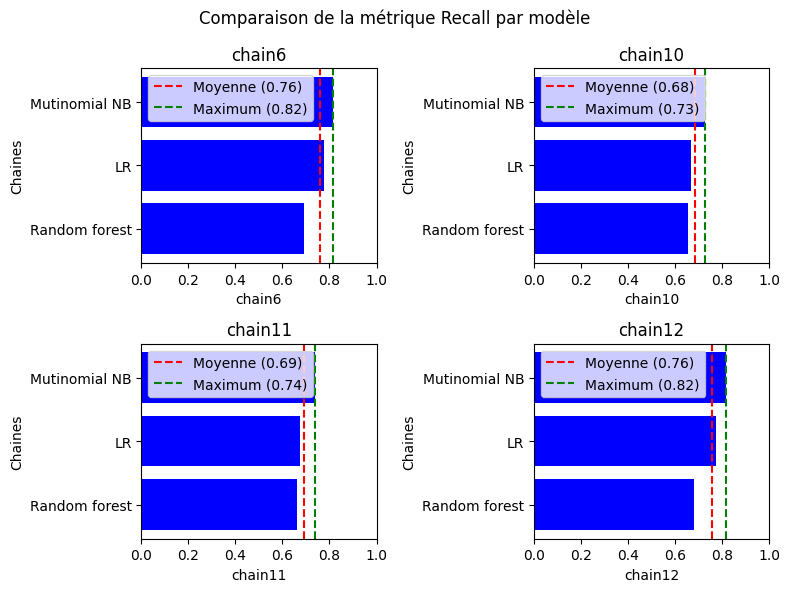

In [66]:
comparer_chaines(classification_reports)

On élimine les chaines 10 et 11 et on essaye une autre valeur pour la fréquence.

## Cinquièmes chaines 

Le pré-traitement appliqué est :
- Nettoyage du texte : supprimer les caractères spéciaux, les ponctuations, les accents convertir en minuscules
- Tokenisation
- Suppression des mots vides
- **Fréquences** 

Et on utilise les traits suivants :

| n° | headline | text | 
| --- | --- | --- | 
| 6 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques | 
| 12 | tf-idf (fréquence = 0.1) | sac de mots (fréquence = 0.01) + informations statistiques | 
| 13 | tf-idf (fréquence = 0.05) | sac de mots (fréquence = 0.05) + informations statistiques | 
| 14 | tf-idf (fréquence = 0.1) | sac de mots (fréquence = 0.05) + informations statistiques | 

In [75]:
chaines = [
    ('chain6', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain12', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_010, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain13', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_005, 'headline'),
            ('text_bow_001',  bow_005, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain14', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_010, 'headline'),
            ('text_bow_001',  bow_005, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
]


In [ ]:
# Ignorer les avertissements spécifiques de scikit-learn
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

classification_reports = run(chaines, models)

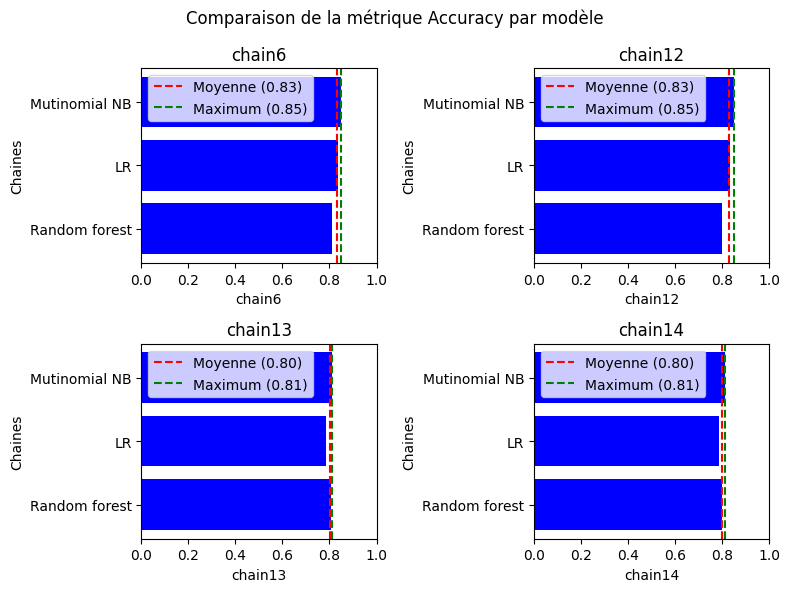

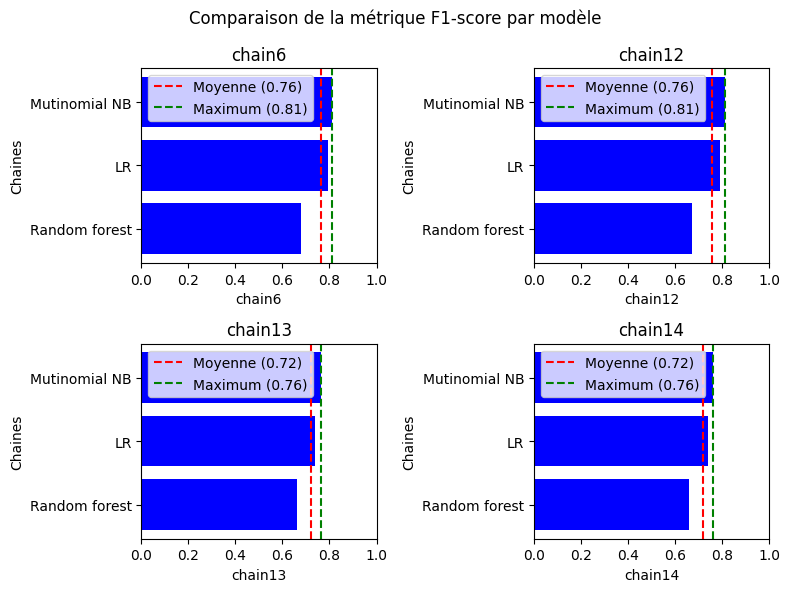

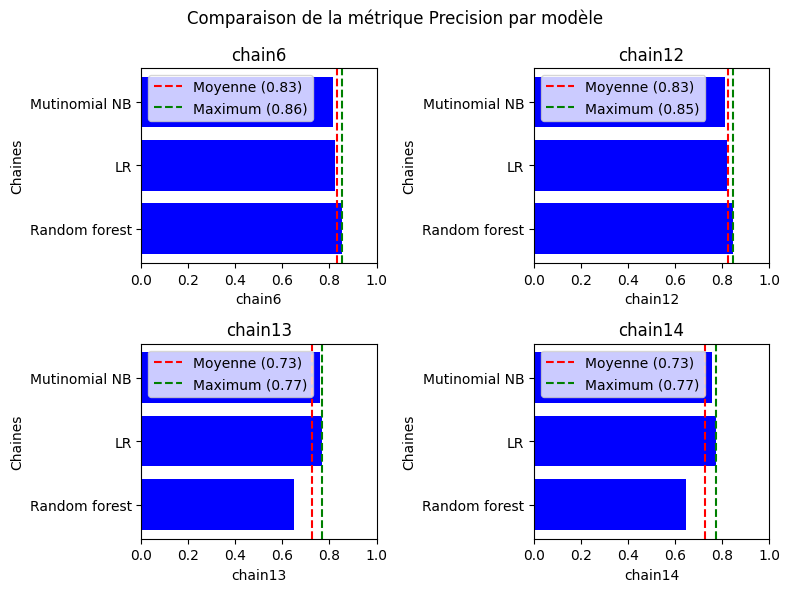

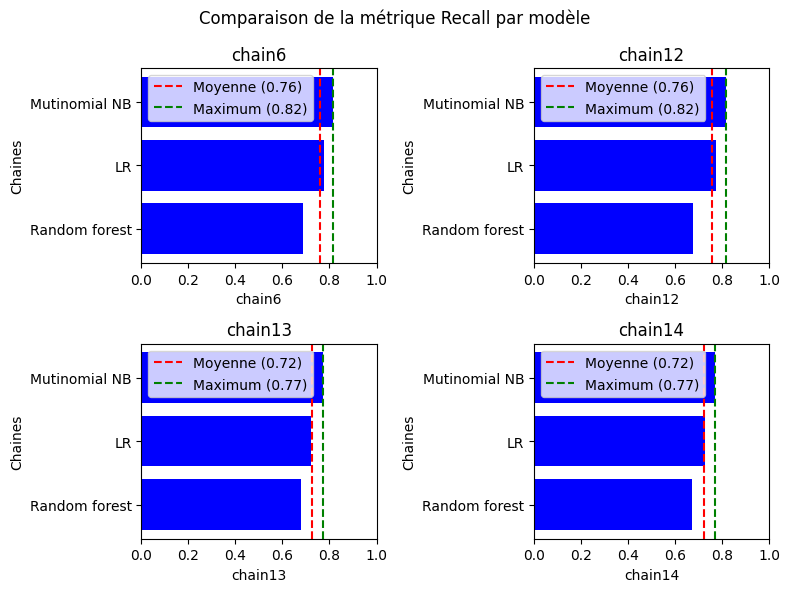

In [77]:
comparer_chaines(classification_reports)

On conserve de nouveau la chaine 6.

## Sixièmes chaines 

Le pré-traitement appliqué est :
- Nettoyage du texte : supprimer les caractères spéciaux, les ponctuations, les accents convertir en minuscules
- Tokenisation
- Suppression des mots vides
- **Lemmatisation**

Et on utilise les traits suivants :

| n° | headline | text | 
| --- | --- | --- | 
| 6 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques | 
| 15 | tf-idf (fréquence = 0.1) | sac de mots (fréquence = 0.01) + informations statistiques | 

In [31]:
chaines = [
    ('chain6', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    ('chain15', ColumnTransformer(
        [
            
            
            ('headline_tfidf_001', 
             Pipeline(
                 [
                     ('lemmatization', FunctionTransformer(lemmatization_transformer)),
                     ('headline_tfidf_001', tfidf_001, 'headline'),
                 ]
             )
             , 'headline'
            ),
            ('text_bow_001',  
             Pipeline(
                 [
                     ('lemmatization', FunctionTransformer(lemmatization_transformer)),
                     ('text_bow_001',  bow_001, 'text'),
                 ]
             )
             , 'text',
            )
            (
             'text_stats',
             Pipeline(
                 [
                     ('lemmatization', FunctionTransformer(lemmatization_transformer)),
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
]


NameError: name 'lemmatization_transformer' is not defined

In [32]:
# Ignorer les avertissements spécifiques de scikit-learn
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

classification_reports = run(chaines, models)

/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_

ValueError: [E1041] Expected a string, Doc, or bytes as input, but got: <class 'pandas.core.series.Series'>

In [ ]:
comparer_chaines(classification_reports)

NameError: name 'classification_reports' is not defined

## Sur le jeu de test